# Where the Bugs are

_Brief abstract/introduction/motivation.  State what the chapter is about in 1-2 paragraphs._
_Then, have an introduction video:_

In [1]:
from bookutils import YouTubeVideo
# YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* _Refer to earlier chapters as notebooks here, as here:_ [Earlier Chapter](Fuzzer.ipynb).

In [2]:
import bookutils

In [3]:
import Tracking

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.ChangeExplorer import <identifier>
```

and then make use of the following features.


_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._


![](PICS/ChangeExplorer-synopsis-1.svg)



## Mining Change Histories

We can mine past changes. We use PyDriller: https://pydriller.readthedocs.io/

In [4]:
from pydriller import RepositoryMining  # https://pydriller.readthedocs.io/

In [5]:
import pickle

In [6]:
class ChangeCounter:
    def __init__(self, repo, filter=None, log=False, **kwargs):
        self.repo = repo
        self.log = log

        if filter is None:
            filter = lambda m: True
        self.filter = filter

        self.changes = {}
        self.messages = {}
        self.sizes = {}
        self.hashes = set()

        self.mine(**kwargs)

In [7]:
class ChangeCounter(ChangeCounter):
    def mine(self, **kwargs):
        miner = RepositoryMining(self.repo, **kwargs)

        for commit in miner.traverse_commits():
            for m in commit.modifications:
                m.hash = commit.hash
                m.committer = commit.committer
                m.committer_date = commit.committer_date
                m.msg = commit.msg

                if self.include(m):
                    self.update_stats(m)

    def include(self, m):
        return self.filter(m)

In [8]:
class ChangeCounter(ChangeCounter):
    def update_stats(self, m):
        if not m.new_path:
            return

        node = tuple(m.new_path.split('/'))

        if m.hash not in self.hashes:
            self.hashes.add(m.hash)
            self.update_size(node, len(m.source_code) if m.source_code else 0)
            self.update_changes(node, m.msg)

        self.update_elems(node, m)

    def update_size(self, node, size):
        self.sizes[node] = size

    def update_changes(self, node, msg):
        self.changes.setdefault(node, 0)
        self.messages.setdefault(node, [])
        self.changes[node] += 1
        self.messages[node].append(msg)

    def update_elems(self, node, m):
        pass

In [9]:
DEBUGGINGBOOK_REPO = 'https://github.com/uds-se/debuggingbook.git'
# DEBUGGINGBOOK_REPO = '..'

In [10]:
def debuggingbook_change_counter(cls):
    def filter(m):
        return m.new_path and not m.new_path.startswith('docs/')

    return cls(DEBUGGINGBOOK_REPO, filter=filter)

In [11]:
from Timer import Timer

In [12]:
with Timer() as t:
    change_counter = debuggingbook_change_counter(ChangeCounter)

t.elapsed_time()

94.56378111697268

In [13]:
list(change_counter.changes.keys())[:10]

[('README.md',),
 ('Chapters.makefile',),
 ('.gitignore',),
 ('full_notebooks', 'index.ipynb~'),
 ('binder', 'README.md'),
 ('notebooks', '99_Appendices.ipynb'),
 ('beta', 'html', 'PICS'),
 ('notebooks', '01_Intro.ipynb'),
 ('html', 'custom.css'),
 ('notebooks', '404.ipynb')]

In [14]:
change_counter.changes[('Chapters.makefile',)]

24

In [15]:
change_counter.messages[('Chapters.makefile',)]

['Initial import',
 'First notebooks',
 'New: make booktitle, authors configurable in Chapters.makefile',
 'Doc fix',
 'Doc fix',
 'New: Tracer',
 'Fix: "Tracer" is ready',
 'New chapter structure',
 'New: added Debugger to chapters',
 'New: depend on shared files, not links',
 'Update',
 'New: ClassDiagram',
 'New chapter',
 "Renamed 'Invariants' to 'Assertions'",
 'Added Time Travel Debugger project',
 'Updated synopsis',
 'New: ChangeDebugger',
 'New: Project 2',
 'New: Slicer',
 'Moved Slicing before Statistical Debugging',
 'New: leaders for missing parts',
 'New: Tracking (very early stage)',
 'Renumbered parts',
 'Need more time for ChangeExplorer']

In [16]:
change_counter.sizes[('Chapters.makefile',)]

3065

## Past Changes

Now, visualize treemap (notebooks/) and give it 

* a size, depending on the number of lines;
* a color, depending on the total number of changes.

https://github.com/mwouts/easyplotly

In [17]:
import easyplotly as ep
import plotly.graph_objects as go

In [18]:
import math

In [19]:
class ChangeCounter(ChangeCounter):
    def map_node_sizes(self):
        # Default: use log scale
        return {node: math.log(self.sizes[node]) if self.sizes[node] else 0
             for node in self.sizes}

        # Alternative: use sqrt size
        return {node: math.sqrt(self.sizes[node]) for node in self.sizes}

        # Alternative: use absolute size
        return self.sizes

    def map_node_color(self, node):
        if node and node in self.changes:
            return self.changes[node]
        return None

    def map_node_text(self, node):
        if node and node in self.changes:
            return self.changes[node]
        return None

    def map_hoverinfo(self):
        return 'label+text'

    def map_colorscale(self):
        return 'YlOrRd'

    def map(self):
        treemap = ep.Treemap(
                     self.map_node_sizes(),
                     text=self.map_node_text,
                     hoverinfo=self.map_hoverinfo(),
                     marker_colors=self.map_node_color,
                     marker_colorscale=self.map_colorscale(),
                     root_label=self.repo,
                     branchvalues='total'
                    )

        fig = go.Figure(treemap)
        fig.update_layout(margin=dict(l=0, r=0, t=30, b=0))

        return fig

In [20]:
change_counter = debuggingbook_change_counter(ChangeCounter)

In [21]:
change_counter.map()

## Past Fixes

In [22]:
class FixCounter(ChangeCounter):
    def include(self, m):
        return super().include(m) and m and m.msg.startswith("Fix:")

In [23]:
class FixCounter(FixCounter):
    def map_node_text(self, node):
        if node and node in self.messages:
            return "<br>".join(self.messages[node])
        return ""

    def map_hoverinfo(self):
        return 'label'

In [24]:
fix_counter = debuggingbook_change_counter(FixCounter)

In [25]:
fix_counter.map()

## Fine-Grained Changes

Our aim: get tuples that are go beyond just files.

* For each file, get a listing of which elements are in which lines.
* Then, for each diff, find out which elems are affected.

### Mapping Elements to Locations

In [26]:
import re

In [27]:
import magic  # https://github.com/ahupp/python-magic

In [28]:
magic.from_buffer('''
#include <stdio.h>

int main(int argc, char *argv[]) {
    printf("Hello, world!\n")
}
''')

'C source, ASCII text'

 Also see http://rigaux.org/language-study/syntax-across-languages.html

In [29]:
DELIMITERS = [
    (
        # Python
        re.compile(r'^python.*'),

        # Beginning of element
        re.compile(r'^(async\s+)?(def|class)\s+(?P<name>\w+)\W.*'),

        # End of element
        re.compile(r'^[^#\s]')
    ),
    (
        # Jupyter Notebooks
        re.compile(r'^(json|exported sgml|jupyter).*'),
        re.compile(r'^\s+"(async\s+)?(def|class)\s+(?P<name>\w+)\W'),
        re.compile(r'^(\s+"[^#\s\\]|\s+\])')
    ),
    (
        # C source code (actually, any { }-delimited language)
        re.compile(r'^(c |c\+\+|c#|java|perl|php).*'),
        re.compile(r'^[^\s].*\s+(?P<name>\w+)\s*[({].*'),
        re.compile(r'^[}]')
    )
]

In [30]:
def rxdelim(s):
    tp = magic.from_buffer(s).lower()
    for rxtp, rxbegin, rxend in DELIMITERS:
        if rxtp.match(tp):
            return rxbegin, rxend

    return None, None

In [31]:
def elem_mapping(s, log=False):
    rxbegin, rxend = rxdelim(s)
    if rxbegin is None:
        return []

    mapping = [None]
    current_elem = None
    lineno = 0

    for line in s.split('\n'):
        lineno += 1

        match = rxbegin.match(line)
        if match:
            current_elem = match.group('name')
        elif rxend.match(line):
            current_elem = None

        mapping.append(current_elem)

        if log:
            print(f"{lineno:3} {current_elem}\t{line}")

    return mapping

In [32]:
some_c_source = """
#include <stdio.h>

int foo(int x) {
    return x;
}

struct bar {
    int x, y;
}

int main(int argc, char *argv[]) {
    return foo(argc);
}

"""
some_c_mapping = elem_mapping(some_c_source, log=True)

  1 None	
  2 None	#include <stdio.h>
  3 None	
  4 foo	int foo(int x) {
  5 foo	    return x;
  6 None	}
  7 None	
  8 bar	struct bar {
  9 bar	    int x, y;
 10 None	}
 11 None	
 12 main	int main(int argc, char *argv[]) {
 13 main	    return foo(argc);
 14 None	}
 15 None	
 16 None	


In [33]:
some_python_source = """
def foo(x):
    return x

class bar(blue):
    x = 25
    def f(x):
        return 26

def main(argc):
    return foo(argc)

"""
some_python_mapping = elem_mapping(some_python_source, log=True)

  1 None	
  2 foo	def foo(x):
  3 foo	    return x
  4 foo	
  5 bar	class bar(blue):
  6 bar	    x = 25
  7 bar	    def f(x):
  8 bar	        return 26
  9 bar	
 10 main	def main(argc):
 11 main	    return foo(argc)
 12 main	
 13 main	


In [34]:
# some_jupyter_source = open("Slicer.ipynb").read()
# some_jupyter_mapping = elem_mapping(some_jupyter_source, log=False)

### Determining Changed Elements

In [35]:
from ChangeDebugger import diff  # minor dependency

In [36]:
from diff_match_patch import diff_match_patch

In [37]:
class FineChangeCounter(ChangeCounter):
    def changed_elems(self, mapping, start, length=0):
        elems = set()
        for line in range(start, start + length + 1):
            if line < len(mapping) and mapping[line]:
                elems.add(mapping[line])

        return elems

    def elem_size(self, elem, mapping, source):
        source_lines = [''] + source.split('\n')
        size = 0

        for line_no in range(len(mapping)):
            if mapping[line_no] == elem:
                size += len(source_lines[line_no])

        return size

In [38]:
fine_change_counter = debuggingbook_change_counter(FineChangeCounter)

In [39]:
assert fine_change_counter.changed_elems(some_python_mapping, 4) == {'foo'}

In [40]:
assert fine_change_counter.changed_elems(some_python_mapping, 4, 1) == {'foo', 'bar'}

In [41]:
assert fine_change_counter.changed_elems(some_python_mapping, 10, 2) == {'main'}

In [42]:
class FineChangeCounter(FineChangeCounter):
    def update_elems(self, node, m):
        old_source = m.source_code_before if m.source_code_before else ""
        new_source = m.source_code if m.source_code else ""
        patches = diff(old_source, new_source)

        old_mapping = elem_mapping(old_source)
        new_mapping = elem_mapping(new_source)

        elems = set()

        for patch in patches:
            old_start_line = patch.start1 + 1
            new_start_line = patch.start2 + 1

            for (op, data) in patch.diffs:
                data_length = data.count('\n')

                if op == diff_match_patch.DIFF_INSERT:
                    elems |= self.changed_elems(old_mapping, old_start_line)
                    elems |= self.changed_elems(new_mapping, new_start_line,
                                                 data_length)
                elif op == diff_match_patch.DIFF_DELETE:
                    elems |= self.changed_elems(old_mapping, old_start_line, 
                                                 data_length)
                    elems |= self.changed_elems(new_mapping, new_start_line)

                old_start_line += data_length
                new_start_line += data_length

        for elem in elems:
            elem_node = node + (elem,)

            self.update_size(elem_node,
                             self.elem_size(elem, new_mapping, new_source))
            self.update_changes(elem_node, m.msg)

In [43]:
with Timer() as t:
    fine_change_counter = debuggingbook_change_counter(FineChangeCounter)

t.elapsed_time()

158.71831831597956

In [44]:
fine_change_counter.map()

## Synopsis

_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

In [45]:
# ignore
from ClassDiagram import display_class_hierarchy

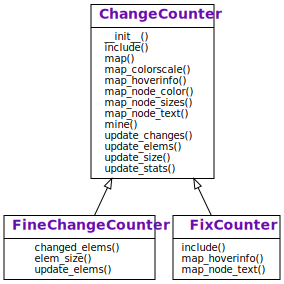

In [46]:
# ignore
display_class_hierarchy([FineChangeCounter, FixCounter],
                        project='debuggingbook')

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [47]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [48]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_